# Cluster

## Objectives

* Fit and evaluate a cluster model to group similar customer behaviour
* Understand profile for each cluster


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/churnometer/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/churnometer'

---

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
      .drop(['customerID', 'TotalCharges', 'Churn', 'tenure' ],axis=1) 
)
print(df.shape)
df.head(3)

(7043, 17)


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85


# Cluster Pipeline considering all data

## ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline([
       
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod'])
      ),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                          threshold=0.6, selection_method="variance") ),


      ("scaler", StandardScaler()  ),
      
    
  ])

  return pipeline_base

## ML Pipeline for Cluster

where `n_components` of PCA and `n_clusters` of KMeans will be updated

In [6]:
### PCA
from sklearn.decomposition import PCA

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### ML algorithms 
from sklearn.cluster import KMeans

def PipelineCluster():
  pipe = PipelineDataCleaningAndFeatureEngineering()
  # pipe.steps.append(["scaler",StandardScaler()])   ##################
  pipe.steps.append(["PCA",PCA(n_components=6, random_state=0)])
  pipe.steps.append(["model",KMeans(n_clusters=4, random_state=0)])
  return pipe

PipelineCluster()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ['PCA', P

## ML Pipeline for a classifier to explain the clusters

We are considering a model that typically offers good results and features importance can be assessed with `.features_importance_`

In [ ]:
# ### Feat Selection
# from sklearn.feature_selection import SelectFromModel

# from sklearn.ensemble import GradientBoostingClassifier
# def PipelineClf2ExplainClusters():
#    pipe = PipelineDataCleaningAndFeatureEngineering()
#    # pipe.steps.append(["scaler",StandardScaler()])
#    pipe.steps.append(["feat_selection",SelectFromModel(GradientBoostingClassifier(random_state=0))])
#    pipe.steps.append(["model",GradientBoostingClassifier(random_state=0)])
#    return pipe
  
# PipelineClf2ExplainClusters()

## Principal Component Analysis (PCA)

Apply PCA separately to find the most suitable `n_components`, update the value on ML Pipeline for Cluster

In [7]:
pipeline_pca = PipelineDataCleaningAndFeatureEngineering()
df_pca = pipeline_pca.fit_transform(df)
print(df_pca.shape)
# df_pca.hea

(7043, 12)


Apply PCA component

In [8]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 6

pca = PCA(n_components=n_components).fit(df_pca)
x_PCA = pca.transform(df_pca) # array with transformed PCA

ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,2),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 6 components explain 77.32% of the data 

             Explained Variance Ratio (%)
Component 0                         23.95
Component 1                         16.69
Component 2                         12.09
Component 3                          8.44
Component 4                          8.28
Component 5                          7.87


## Elbow Analysis

Find the most suitable `n_clusters`, update the value on ML Pipeline for Cluster


Prepare data for analysis
  * You need to clean and feature engineer your data using the pipeline without the model

In [9]:
pipeline_cluster = PipelineCluster()
pipeline_elbow = Pipeline(pipeline_cluster.steps[:-1])
df_elbow = pipeline_elbow.fit_transform(df)

print(df_elbow.shape,'\n')
df_elbow

(7043, 6) 



array([[-0.68919356,  3.56339462,  1.97174278,  0.2049194 , -1.22116345,
         0.69554574],
       [ 0.1415899 ,  0.83772622, -0.70728486, -0.45572329,  0.92179106,
        -1.0317484 ],
       [-0.82232835,  1.01378854, -0.78350144, -0.68236061,  0.67421507,
        -0.64051617],
       ...,
       [ 0.47325016,  3.1011415 ,  2.66311523, -0.59200886, -1.79012103,
         0.93946608],
       [-2.3222811 , -0.81720084,  0.24326504, -0.27187354,  1.10540767,
         1.76414787],
       [-0.01872293, -0.5184082 , -0.19450983,  0.61655991,  1.58558089,
        -0.82484869]])

Elbow Analysis

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


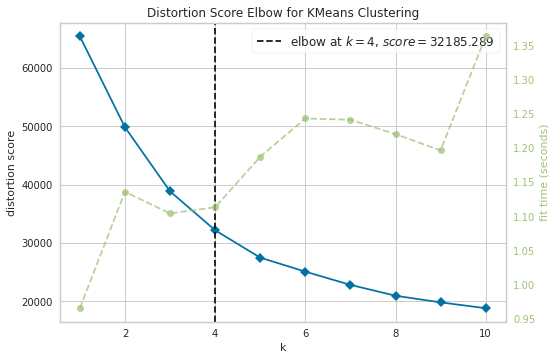

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_elbow) 
visualizer.show() 
plt.show()

## Fit Cluster Pipeline

Quick recap in our data for training cluster pipeline

In [11]:
X = df.copy()
print(X.shape)
X.head(3)

(7043, 17)


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85


Fit Cluster pipeline

In [12]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'Partner', 'Dependents',
                                                     'PhoneService',
                                                     'MultipleLines',
                                              

## Add cluster labels to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset
* There are clusters with more user than other clusters

* Clusters frequencies 
   Clusters
0      0.40
2      0.29
3      0.22
1      0.10 




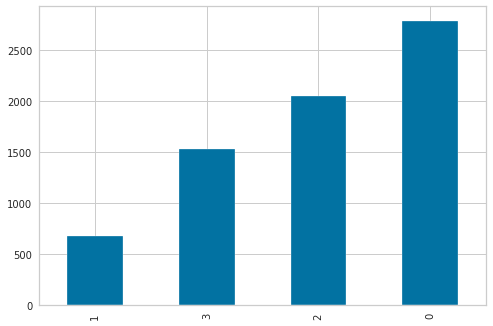

In [13]:
X['Clusters'] = pipeline_cluster['model'].labels_

print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

This is how our data look like from now
  * Check the last column: `Clusters`

In [14]:
print(X.shape)
X.head(3)

(7043, 18)


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Clusters
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,1
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,0
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,0


Here we are saving the cluster predictions for this pipeline to use in a fututre moment. We will get back to that soon

In [15]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       1
1       0
2       0
3       1
4       0
       ..
7038    2
7039    2
7040    1
7041    0
7042    2
Name: Clusters, Length: 7043, dtype: int32

## Evaluate Clusters silhouette

To evaluate clusters silhouete we need:
  * data transformed (transform data in the pipeline wihout model step)

In [16]:
pipeline_silhouette = Pipeline(pipeline_cluster.steps[:-1])
df_transformed = pipeline_silhouette.transform(df)
df_transformed.shape

(7043, 6)

Plot silhouttes

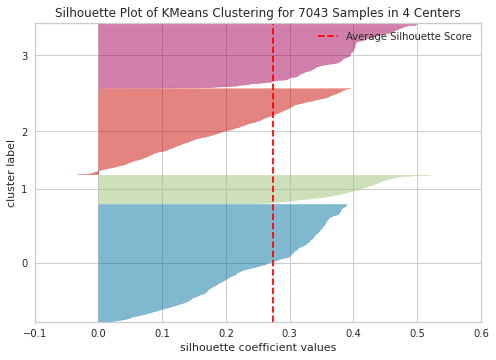

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')

visualizer.fit(df_transformed)
visualizer.show()
plt.show()

In [18]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'Partner', 'Dependents',
                                                     'PhoneService',
                                                     'MultipleLines',
                                              

## Fit a classifier, where target is cluster predictions and features remaining variables

We are in a moment where we have predictions from the cluster pipeline, but we don't have a meaning for them yet. 
* We seek to understand clusters' profile

We need to find the most relevant variables, to define each cluster in terms of each relevant variable
* Our new dataset has `Clusters`, which will be the **target for a classifier**. The most relevant features for this classifier, will be the most relevant variables when we use a classifier where the target is `Clusters`!

We copy `X` to a DataFrame `df_clf`

In [19]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(7043, 18)


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Clusters
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,1
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,0
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,0


Split Train and Test sets

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, X_test.shape)

(5634, 17) (1409, 17)


Create and fit a classifier pipeline to learn most relevant features that determine a cluster 

We are considering a model that typically offers good results and features importance can be assessed with `.features_importance_`

In [21]:
### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithm
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.tree import DecisionTreeClassifier


# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from xgboost import XGBClassifier

def PipelineClf2ExplainClusters():
   pipe = PipelineDataCleaningAndFeatureEngineering()
   # pipe.steps.append(["scaler",StandardScaler()])
   pipe.steps.append(["feat_selection",SelectFromModel(GradientBoostingClassifier(random_state=0))])
   pipe.steps.append(["model",GradientBoostingClassifier(random_state=0)])
   return pipe
  
PipelineClf2ExplainClusters()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ['feat_se

In [22]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'InternetService',
                                                     'OnlineSecurity',
                                                     'OnlineBackup',
                                                   

## Evaluate classifier performance on Train and Test Sets

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2222
           1       1.00      1.00      1.00       542
           2       0.89      0.83      0.86      1647
           3       1.00      1.00      1.00      1223

    accuracy                           0.92      5634
   macro avg       0.94      0.94      0.94      5634
weighted avg       0.92      0.92      0.92      5634



In [24]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       565
           1       1.00      1.00      1.00       140
           2       0.85      0.80      0.83       399
           3       1.00      1.00      1.00       305

    accuracy                           0.90      1409
   macro avg       0.93      0.93      0.93      1409
weighted avg       0.90      0.90      0.90      1409



## Assess Most Important Features that define a cluster

In [ ]:
# pipeline_cluster['SmartCorrelatedSelection'].correlated_feature_sets_ # 3 groups

In [ ]:
# pipeline_cluster['SmartCorrelatedSelection'].features_to_drop_ 
# there was 17, 5 are dropped, we keep 12

In [ ]:
# Pipeline(pipeline_cluster.steps[:data_cleaning_feat_eng_steps])

In [25]:
pipeline_clf_cluster['SmartCorrelatedSelection'].correlated_feature_sets_ #['feat_selection'].get_support()

[{'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'TechSupport'}]

In [26]:
pipeline_clf_cluster['SmartCorrelatedSelection'].features_to_drop_

['OnlineSecurity', 'DeviceProtection', 'TechSupport']

* These are the 5 most important features in descending order. The model was trained on them: 
['OnlineBackup', 'MonthlyCharges', 'PhoneService', 'Partner', 'Dependents'] 



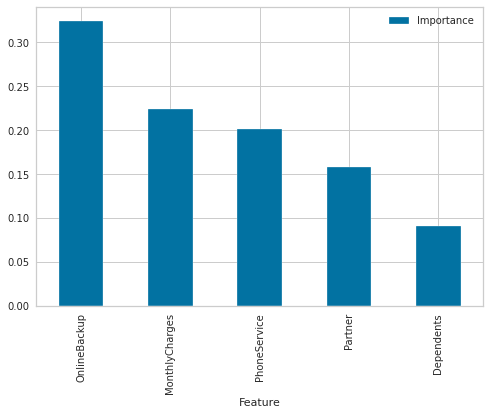

In [27]:
# after data cleaning and feat engineering, the feature space changes
data_cleaning_feat_eng_steps = 2 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
          'Importance': pipeline_clf_cluster['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features = df_feature_importance['Feature'].to_list() # reassign best features in importance order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

We will store the best_features for future usage. We will get back to that soon

In [28]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['OnlineBackup', 'MonthlyCharges', 'PhoneService', 'Partner', 'Dependents']

## Cluster Analysis

* Table with description for all Clusters

In [29]:
def Clusters_IndividualDescription(EDA_Cluster,cluster):

  ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
  for col in EDA_Cluster.columns:
    
    try:  # eventually a given cluster will have only mssing data for a given variable
      
      if EDA_Cluster[col].dtypes == 'object':
        
        top_frequencies = EDA_Cluster.dropna(subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
        Description = ''
        
        for x in range(len(top_frequencies)):
          freq = top_frequencies.iloc[x]
          category = top_frequencies.index[x][0]
          CategoryPercentage = int(round(freq*100,0))
          statement =  f"'{category}': {CategoryPercentage}% , "  
          Description = Description + statement
        
        ClustersDescription.at[0,col] = Description[:-2]


      
      elif EDA_Cluster[col].dtypes in ['float', 'int']:
        DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
        Q1 = int(round(DescStats.iloc[4,0],0))
        Q3 = int(round(DescStats.iloc[6,0],0))
        Description = f"{Q1} -- {Q3}"
        ClustersDescription.at[0,col] = Description
    
    
    except Exception as e:
      ClustersDescription.at[0,col] = 'Not available'
      print(f"** Error Exception: {e} - cluster {cluster}, variable {col}")
  
  ClustersDescription['Cluster'] = str(cluster)
  
  return ClustersDescription


def DescriptionAllClusters(df_cluster_profile):

  DescriptionAllClusters = pd.DataFrame(columns=df_cluster_profile.drop(['Clusters'],axis=1).columns)
  for cluster in df_cluster_profile.sort_values(by='Clusters')['Clusters'].unique():
    
      EDA_ClusterSubset = df_cluster_profile.query(f"Clusters == {cluster}").drop(['Clusters'],axis=1)
      ClusterDescription = Clusters_IndividualDescription(EDA_ClusterSubset,cluster)
      DescriptionAllClusters = DescriptionAllClusters.append(ClusterDescription)

  
  DescriptionAllClusters.set_index(['Cluster'],inplace=True)
  return DescriptionAllClusters


* Cluster distribution per Variable (absolute and relative levels)

In [30]:
import plotly.express as px
def cluster_distribution_per_variable(df,target):


  df_bar_plot = df.value_counts(["Clusters", target]).reset_index() 
  df_bar_plot.columns = ['Clusters',target,'Count']
  df_bar_plot[target] = df_bar_plot[target].astype('object')

  print(f"Clusters distribution across {target} levels")
  fig = px.bar(df_bar_plot, x='Clusters',y='Count',color=target,width=800, height=500)
  fig.update_layout(xaxis=dict(tickmode= 'array',tickvals= df['Clusters'].unique()))
  fig.show()


  df_relative = (df
                 .groupby(["Clusters", target])
                 .size()
                 .groupby(level=0)
                 .apply(lambda x:  100*x / x.sum())
                 .reset_index()
                 .sort_values(by=['Clusters'])
                 )
  df_relative.columns = ['Clusters',target,'Relative Percentage (%)']
 

  print(f"Relative Percentage (%) of {target} in each cluster")
  fig = px.line(df_relative, x='Clusters',y='Relative Percentage (%)',color=target,width=800, height=500)
  fig.update_layout(xaxis=dict(tickmode= 'array',tickvals= df['Clusters'].unique()))
  fig.update_traces(mode='markers+lines')
  fig.show()
 


---

We will study the profile for the main variables that define a cluster


In [31]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

,OnlineBackup,MonthlyCharges,PhoneService,Partner,Dependents,Clusters
0,Yes,29.85,No,Yes,No,1
1,No,56.95,Yes,No,No,0
2,Yes,53.85,Yes,No,No,0


Load Churn levels

In [32]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

,Churn
0,0
1,0
2,1


### Cluster profile on most important features

Considering `df_cluster_profile` and `df_churn`

In [33]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(pd.concat([df_cluster_profile,df_churn], axis=1))
clusters_profile

,OnlineBackup,MonthlyCharges,PhoneService,Partner,Dependents,Churn
Cluster,,,,,,
0,"'No': 67% , 'Yes': 33%",69 -- 94,'Yes': 100%,"'No': 79% , 'Yes': 21%","'No': 96% , 'Yes': 4%","'0': 55% , '1': 45%"
1,"'No': 58% , 'Yes': 42%",34 -- 51,'No': 100%,"'No': 54% , 'Yes': 46%","'No': 70% , 'Yes': 30%","'0': 75% , '1': 25%"
2,"'Yes': 60% , 'No': 40%",73 -- 101,'Yes': 100%,"'Yes': 86% , 'No': 14%","'Yes': 56% , 'No': 44%","'0': 84% , '1': 16%"
3,"'No internet service': 100% , 'Yes': 0% , 'No': 0%",20 -- 21,'Yes': 100%,"'No': 52% , 'Yes': 48%","'No': 58% , 'Yes': 42%","'0': 93% , '1': 7%"


### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

# Fit New Cluster Pipeline only on most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline with the variables that are most important to define the clusters from the previous pipeline

In [35]:
best_features_pipeline_all_variables

['OnlineBackup', 'MonthlyCharges', 'PhoneService', 'Partner', 'Dependents']

## Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will
1. Conduct a PCA analysis, with the same amount of components from 
previous study, in a dataset only with `best_features_pipeline_all_variables` and check if new components have still almost all data variance 
2. Conduct a elbow study and check if the same number of clusters is suggested
3. Fit new cluster pipeline and compare if the both clusters predictions are "equivalent"
4. Compare silhoutte score
5. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar
6. Check if the most important features for the classifier are the same.
7. Compare if the cluster profile from both cases are "equivalent"

If we are happy to say **yes** for them, you can use a cluster pipeline with a reduced feature space!
* The **gain** is that in real time (which is the major purpose of Machine Learning) you will need less variables for predicting cluster for your prospects.

## Consider the data with the most relevant variables

In [36]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

,OnlineBackup,MonthlyCharges,PhoneService,Partner,Dependents
0,Yes,29.85,No,Yes,No
1,No,56.95,Yes,No,No
2,Yes,53.85,Yes,No,No


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [37]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline([
        # we updated the pipeline, considering only the most important variables from previous pipeline      
       ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  # variables = ['PaymentMethod', 'InternetService',
                                                  #              'DeviceProtection','OnlineSecurity']
                                                  variables = ['OnlineBackup', 'PhoneService',
                                                                'Partner',	'Dependents'] ) ),

        # it doesnt need SmartCorrelation

        ("scaler", StandardScaler()  ),

    ])

  return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler())])

In [38]:
def PipelineCluster():
  pipe = PipelineDataCleaningAndFeatureEngineering()
  # pipe.steps.append(["scaler",StandardScaler()])   ##################
  # pipe.steps.append(["PCA",PCA(n_components=6, random_state=0)])
  pipe.steps.append(["model",KMeans(n_clusters=4, random_state=0)])
  return pipe

PipelineCluster()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler()),
                ['model', KMeans(n_clusters=4, random_state=0)]])

## Apply PCA and compare to previous PCA

YOU DONT NEED TO APPLY PCA, SINCE YOU HAVE ALREADY THE MOST IMPORTANT FEATURES!!!!

It needs the dataset after data cleaning and feature engineering

In [ ]:
# pipeline_pca = PipelineDataCleaningAndFeatureEngineering()
# df_pca = pipeline_pca.fit_transform(df_reduced)
# print(df_pca.shape)

Apply PCA component

In [ ]:
# n_components = 5

# pca = PCA(n_components=n_components).fit(df_pca)
# x_PCA = pca.transform(df_pca) # array with transformed PCA

# ComponentsList = ["Component " + str(number) for number in range(n_components)]
# dfExplVarRatio = pd.DataFrame(
#     data= np.round(100 * pca.explained_variance_ratio_ ,2),
#     index=ComponentsList,
#     columns=['Explained Variance Ratio (%)'])

# PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

# print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
# print(dfExplVarRatio)

## Apply Elbow analysis and compare to previous Elbow analysis

Prepare data for analysis
  * You need to clean and feature engineer your data using the pipeline without the model

In [ ]:
# PipelineCluster()

In [40]:
pipeline_cluster = PipelineCluster()
pipeline_elbow = Pipeline(pipeline_cluster.steps[:-1])
df_elbow = pipeline_elbow.fit_transform(df_reduced)

print(df_elbow.shape,'\n')
df_elbow

(7043, 5) 



array([[-1.18077674, -1.16032292, -3.05401039, -1.03453023, -0.65401193],
       [ 0.17365495, -0.25962894,  0.32743831,  0.96662231, -0.65401193],
       [-1.18077674, -0.36266036,  0.32743831,  0.96662231, -0.65401193],
       ...,
       [ 0.17365495, -1.1686319 , -3.05401039, -1.03453023,  1.5290241 ],
       [ 0.17365495,  0.32033821,  0.32743831, -1.03453023, -0.65401193],
       [ 0.17365495,  1.35896134,  0.32743831,  0.96662231, -0.65401193]])

Elbow Analysis

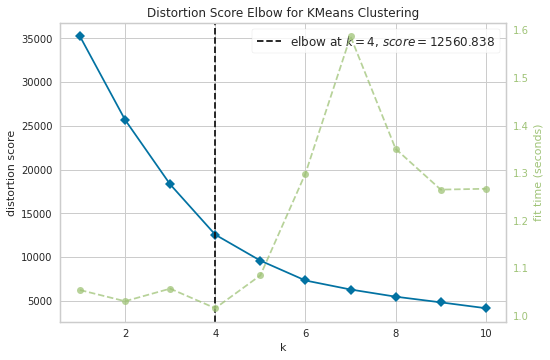

In [41]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_elbow) 
visualizer.show() 
plt.show()

The same number of clusters is suggested! :)

## Fit New Cluster Pipeline

We set X as our training set for cluster. It is a copy of df_reduced

In [42]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

(7043, 5)


,OnlineBackup,MonthlyCharges,PhoneService,Partner,Dependents
0,Yes,29.85,No,Yes,No
1,No,56.95,Yes,No,No
2,Yes,53.85,Yes,No,No


Fit Cluster pipeline

In [43]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler()),
                ['model', KMeans(n_clusters=4, random_state=0)]])

## Add cluster predictions to dataset

We add a column "Cluster" to the data and check clusters distribution
* Clusters don't look to be imbalanced

* Clusters frequencies 
   Clusters
1      0.35
2      0.33
0      0.22
3      0.10 




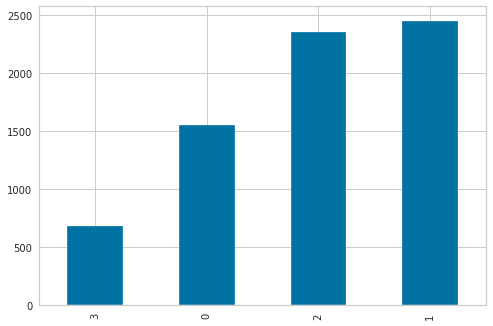

In [44]:
X['Clusters'] = pipeline_cluster['model'].labels_

print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar');

## Compare current cluster labels to previous cluster labels

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" from the previous cluster

These are the predictions from the **previous** cluster pipeline 

In [45]:
cluster_predictions_with_all_variables

0       1
1       0
2       0
3       1
4       0
       ..
7038    2
7039    2
7040    1
7041    0
7042    2
Name: Clusters, Length: 7043, dtype: int32

And these are the predictions from **current** cluster pipeline (trained with `df_reduced`)

In [46]:
cluster_anwers_with_major_variables = X['Clusters'] 
cluster_anwers_with_major_variables

0       3
1       1
2       1
3       3
4       1
       ..
7038    2
7039    2
7040    3
7041    2
7042    1
Name: Clusters, Length: 7043, dtype: int32

---

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**
* We say equivalent in quotes, because we can't expect that a cluster label 0 in the previous cluster will have the same label in the current cluster. Eventually label 0 in previous cluster pipeline will be a different label in current cluster pipeline
* When we reach this **equivalence**, it means both clusters "clustered" in a similar way but with different labels. And this is fine, since the label itself doesn't have meaning. We will look for the meaning after. 

In [47]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_anwers_with_major_variables))

[[  26 2163  598    0]
 [   0    0    0  682]
 [   3  288 1755    0]
 [1526    2    0    0]]


Conclusion
* We see that both Clusters Pipelines are not predicting the data 100% equivalent, since few data points have different meaning for each pipeline. 
* However this is fine, and we say yes for this criteria. This is part of the trade-off we are up to.

## Evaluate current Clusters silhouette

* To evaluate clusters silhouete we need:
  * data transformed (transform data in the pipeline wihout model step)
  * clusters arrays

In [48]:
pipeline_silhouette = Pipeline(pipeline_cluster.steps[:-1])
df_transformed = pipeline_silhouette.transform(df_reduced)
df_transformed.shape

(7043, 5)

Evaluate Cluster Silhouette

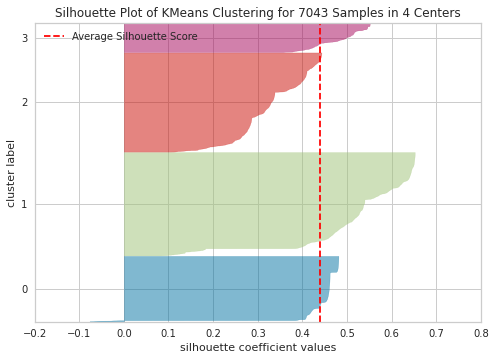

In [49]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')

visualizer.fit(df_transformed)
visualizer.show()
plt.show()

The silhoutte score from both pipelines are similar! Now it has even increased a bit :)

## Rewrite ML Pipeline for a classifier to explain the clusters

We want again to explain the major variables for our clusters

We copy `X` to a DataFrame `df_clf`, just to separate the concerns

In [50]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(7043, 6)


,OnlineBackup,MonthlyCharges,PhoneService,Partner,Dependents,Clusters
0,Yes,29.85,No,Yes,No,3
1,No,56.95,Yes,No,No,1
2,Yes,53.85,Yes,No,No,1


Split Train and Test sets

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, X_test.shape)

(5634, 5) (1409, 5)


Rewrite pipeline to explain clusters

In [52]:
def PipelineClf2ExplainClusters():
   pipe = PipelineDataCleaningAndFeatureEngineering()
   # no feature selection step
   # pipe.steps.append(["feat_selection",SelectFromModel(GradientBoostingClassifier(random_state=0))])
   pipe.steps.append(["model",GradientBoostingClassifier(random_state=0)])
   return pipe

PipelineClf2ExplainClusters()




Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler()),
                ['model', GradientBoostingClassifier(random_state=0)]])

## Fit a classifier, where target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [53]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler()),
                ['model', GradientBoostingClassifier(random_state=0)]])

## Evaluate classifier performance on Train and Test Sets

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1245
           1       1.00      1.00      1.00      1955
           2       1.00      1.00      1.00      1892
           3       1.00      1.00      1.00       542

    accuracy                           1.00      5634
   macro avg       1.00      1.00      1.00      5634
weighted avg       1.00      1.00      1.00      5634



In [55]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       310
           1       1.00      1.00      1.00       498
           2       1.00      1.00      1.00       461
           3       1.00      1.00      1.00       140

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



The performance on Train and Test sets are similar, comparing to the previous pipeline! :)

## Assess Most Important Features

They help the most to define a cluster, compare with previous pipeline
* we can use .feature_importances_ since it is a tree based model
* since we don't have feature selection step, we just get best_features as the Xtrain columns


In [56]:
# Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns
pipeline_clf_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler()),
                ['model', GradientBoostingClassifier(random_state=0)]])

* These are the 5 most important features in descending order. The model was trained on them: 
['Partner', 'OnlineBackup', 'MonthlyCharges', 'PhoneService', 'Dependents']


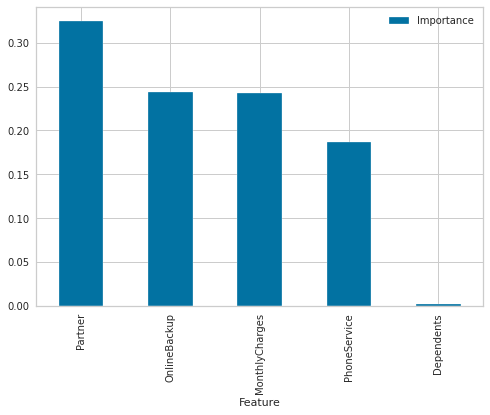

In [57]:
best_features = X_train.columns.to_list()


# after data cleaning and feat engineering, the feature space changes
# data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
# columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
#                                         .transform(X_train)
#                                         .columns)

# best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()].to_list()


# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature':best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
.sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Cluster Analysis

We will study the profile for the main variables that define a cluster


In [58]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

,Partner,OnlineBackup,MonthlyCharges,PhoneService,Dependents,Clusters
0,Yes,Yes,29.85,No,No,3
1,No,No,56.95,Yes,No,1
2,No,Yes,53.85,Yes,No,1


Load Churn levels

In [59]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

,Churn
0,0
1,0
2,1


### Cluster profile on most important features

Considering `df_cluster_profile` and `df_churn`

In [60]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(pd.concat([df_cluster_profile,df_churn], axis=1))
clusters_profile

,Partner,OnlineBackup,MonthlyCharges,PhoneService,Dependents,Churn
Cluster,,,,,,
0,"'No': 53% , 'Yes': 47%","'No internet service': 98% , 'No': 2%",20 -- 21,'Yes': 100%,"'No': 57% , 'Yes': 43%","'0': 92% , '1': 8%"
1,'No': 100%,"'No': 64% , 'Yes': 36%",67 -- 93,'Yes': 100%,"'No': 93% , 'Yes': 7%","'0': 59% , '1': 41%"
2,'Yes': 100%,"'Yes': 53% , 'No': 47%",74 -- 100,'Yes': 100%,"'No': 55% , 'Yes': 45%","'0': 75% , '1': 25%"
3,"'No': 54% , 'Yes': 46%","'No': 58% , 'Yes': 42%",34 -- 51,'No': 100%,"'No': 70% , 'Yes': 30%","'0': 75% , '1': 25%"


### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

## Which pipeline should I keep?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Conduct a PCA analysis, with the same amount of components from 
previous study, in a dataset only with `best_features_pipeline_all_variables` and check if new components have still almost all data variance 
2. Conduct a elbow study and check if the same number of clusters is suggested
3. Fit new cluster pipeline and compare if the both clusters predictions are "equivalent"
4. Compare silhoutte score
5. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar
6. Check if the most important features for the classifier are the same.
7. Compare if the cluster profile from both cases are "equivalent"

We are happy with all criteria above for the new Cluster Pipeline

* All 7 criteria support the second pipeline. In addition, there is a great gain to have less variables for predicting live data

In [62]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService',
                                           'Partner', 'Dependents'])),
                ('scaler', StandardScaler()),
                ['model', KMeans(n_clusters=4, random_state=0)]])

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Cluster pipeline

In [ ]:
pipeline_cluster

In [ ]:
joblib.dump(value=pipeline_cluster ,
            filename=f"{file_path}/cluster_pipeline.pkl")

## Train Set

In [63]:
print(df_reduced.shape)
df_reduced.head(3)

(7043, 5)


,OnlineBackup,MonthlyCharges,PhoneService,Partner,Dependents
0,Yes,29.85,No,Yes,No
1,No,56.95,Yes,No,No
2,Yes,53.85,Yes,No,No


In [ ]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [ ]:
clusters_profile

In [ ]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

In [ ]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')

visualizer.fit(df_transformed)
visualizer.show()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_transformed)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Good job, clear the cell ouputs, run git commands to add, commit and push files to the repo. Next, we will move on to create our dashboard!